In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autokeras as ak
import tensorflow as tf
import os

In [2]:
import logging

logging.basicConfig(level = logging.INFO)

gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     logging.info(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    logging.info(e)
    
    
logging.info("Tensorflow Version is {}".format(tf.__version__))
logging.info("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
logging.info(device_lib.list_local_devices())
tf.device('/device:XLA_GPU:0')

INFO:root:Tensorflow Version is 2.4.0-rc3
INFO:root:Keras Version is 2.4.0
INFO:root:[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9432837825740413385
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5242880000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8372761631892607751
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:03:00.0, compute capability: 7.5"
]


In [3]:
data = np.load('/home/ML4NO/Data/n1000000_0910_classification.npz')

In [4]:
data_all = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune'], data['ve_t2hk'], data['vu_t2hk'], data['vebar_t2hk'], data['vubar_t2hk']])
target = data['cpv']

x_train = data_all[:10000]
y_train = target[:10000]
x_train2 = data_all[10000:900000]
y_train2 = target[10000:900000]
x_test = data_all[900000:]
y_test = target[900000:]

In [5]:
clf = ak.StructuredDataClassifier(overwrite=True, max_trials=50)
clf.fit(x_train, y_train,
           validation_split = 0.1,
           batch_size=64,
           epochs=20,
           verbose=1,
           shuffle = True
        )

Trial 9 Complete [00h 01m 01s]
val_accuracy: 0.9813596606254578

Best val_accuracy So Far: 0.9923245906829834
Total elapsed time: 00h 09m 08s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/20
157/157 [==============================] - 5s 16ms/step - loss: 0.5868 - accuracy: 0.6745
Epoch 2/20
157/157 [==============================] - 3s 16ms/step - loss: 0.1970 - accuracy: 0.9357
Epoch 3/20
157/157 [==============================] - 2s 16ms/step - loss: 0.1381 - accuracy: 0.9544
Epoch 4/20
157/157 [==============================] - 2s 16ms/step - loss: 0.1175 - accuracy: 0.9632
Epoch 5/20
157/157 [==============================] - 2s 16ms/step - loss: 0.1079 - accuracy: 0.9674
Epoch 6/20
157/157 [==============================] - 2s 16ms/step - loss: 0.1043 - accuracy: 0.9686
Epoch 7/20
157/157 [==============================] - 3s 16ms/step - loss: 0.0933 - accuracy: 0.9714
Epoch 8/20
157/157 [==============================] - 2s 16ms/step - loss: 0.0925 - accuracy: 0.9730
Epoch 9/20
157/157 [==============================] - 2s 16ms/step - loss: 0.0901 - accuracy: 0.9738
Epoch 10/20
157/157 [==============================] - 2s 16ms/step - loss: 0.0869 - accura


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets


In [6]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 304)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 304)               0         
_________________________________________________________________
normalization (Normalization (None, 304)               609       
_________________________________________________________________
dense (Dense)                (None, 32)                9760      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

In [7]:
model.fit(x_train2, y_train2,
           validation_split = 0.1,
           batch_size=64,
           epochs=5,
           verbose=1,
           shuffle = True
         )

Epoch 1/5
12516/12516 [==============================] - 213s 17ms/step - loss: 0.0505 - accuracy: 0.9880 - val_loss: 0.0528 - val_accuracy: 0.9890
Epoch 2/5
12516/12516 [==============================] - 209s 17ms/step - loss: 0.0388 - accuracy: 0.9913 - val_loss: 0.0361 - val_accuracy: 0.9920
Epoch 3/5
12516/12516 [==============================] - 207s 17ms/step - loss: 0.0354 - accuracy: 0.9921 - val_loss: 0.0299 - val_accuracy: 0.9928
Epoch 4/5
12516/12516 [==============================] - 208s 17ms/step - loss: 0.0328 - accuracy: 0.9928 - val_loss: 0.0407 - val_accuracy: 0.9927
Epoch 5/5
12516/12516 [==============================] - 206s 16ms/step - loss: 0.0301 - accuracy: 0.9934 - val_loss: 0.0235 - val_accuracy: 0.9947


In [8]:
index = 1
while os.path.isfile('/home/ML4NO/ML/Classification/models/0910_{}.h5'.format(index)):
    index += 1
model.save('/home/ML4NO/ML/Classification/models/0910_{}.h5'.format(index), overwrite=False, include_optimizer=True)

In [10]:
scale_steps = np.logspace(-3, 0, 10)
before_train_loss = []
after_train_loss = []

for scale in scale_steps:
    x_train2_gen = np.random.normal(x_train2, np.sqrt(x_train2)*scale)
    x_test_gen = np.random.normal(x_test, np.sqrt(x_test)*scale)

    before_train_loss.append(model.evaluate(x_test_gen, y_test)[0])

    model.fit(x_train2_gen, y_train2,
               validation_split = 0.1,
               batch_size=64,
               epochs=5,
               verbose=1,
               shuffle = True
             )
    after_train_loss.append(model.evaluate(x_test_gen, y_test)[0])

3125/3125 [==============================] - 38s 12ms/step - loss: 0.0229 - accuracy: 0.9949
Epoch 1/5
12516/12516 [==============================] - 205s 16ms/step - loss: 0.0293 - accuracy: 0.9937 - val_loss: 0.0219 - val_accuracy: 0.9950
Epoch 2/5
12516/12516 [==============================] - 202s 16ms/step - loss: 0.0279 - accuracy: 0.9940 - val_loss: 0.0334 - val_accuracy: 0.9937
Epoch 3/5
12516/12516 [==============================] - 212s 17ms/step - loss: 0.0271 - accuracy: 0.9942 - val_loss: 0.0209 - val_accuracy: 0.9953
Epoch 4/5
12516/12516 [==============================] - 210s 17ms/step - loss: 0.0261 - accuracy: 0.9944 - val_loss: 0.0243 - val_accuracy: 0.9945
Epoch 5/5
3125/3125 [==============================] - 37s 12ms/step - loss: 0.0221 - accuracy: 0.9957
Epoch 1/5
12516/12516 [==============================] - 210s 17ms/step - loss: 0.0255 - accuracy: 0.9946 - val_loss: 0.0332 - val_accuracy: 0.9939
Epoch 2/5
12516/12516 [==============================] - 209s 17

In [11]:
model_index = index
index = 1
path = '/home/ML4NO/ML/Classification/models_furthurTrain/0910_{}_{}.h5'
while os.path.isfile(path.format(model_index, index)):
    index += 1
model.save(path.format(model_index, index))
outfile = {'scale_steps': scale_steps,
           'before_train_loss': before_train_loss,
           'after_train_loss' :after_train_loss}
np.save(file = '/home/ML4NO/ML/Classification/models_furthurTrain/0910_{}_{}_result.npy'.format(model_index, index),
        arr = outfile)

In [12]:
x_test2_gen = np.random.poisson(x_test)

for i in range(5):
    x_train2_gen = np.random.poisson(x_train2)
    
    model.fit(x_train2_gen, y_train2,
              validation_split=0.1,
               batch_size=64,
               epochs=1,
               verbose=1,
               shuffle = True
             )
model.evaluate(x_test2_gen, y_test)

3125/3125 [==============================] - 48s 15ms/step - loss: 0.1963 - accuracy: 0.9305


[0.19626706838607788, 0.9304999709129333]

In [13]:
pred = model.predict(x_test2_gen)

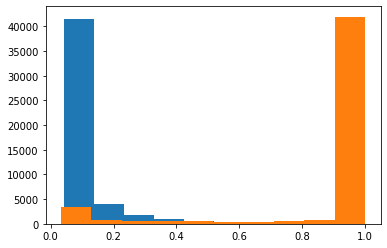

In [14]:
cpc = np.where(y_test == 0)
cpv = np.where(y_test == 1)
plt.hist(pred[cpc])
plt.hist(pred[cpv])
plt.show()

In [15]:
furthur_index = index
index = 1
path = '/home/ML4NO/ML/Classification/models_PoissonTrain/0910_{}_{}_{}.h5'
while os.path.isfile(path.format(model_index, furthur_index, index)):
    index += 1
model.save(path.format(model_index, furthur_index, index))